# Amazon Product reviews playground
This note contains my playground for amazon products using Apache Livy to communicate with Spark

In [1]:
spark.version

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
5,None,spark,idle,,,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

res1: String = 2.4.4


In [2]:
val base_path = "/media/ohtar10/Adder-Storage/datasets"

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

base_path: String = /media/ohtar10/Adder-Storage/datasets


In [3]:
val metadata_path = base_path + "/amazon_products/reviews/metadata.json.gz"
val reviews_path = base_path + "/amazon_products/reviews/aggressive_dedup.json.gz"

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

metadata_path: String = /media/ohtar10/Adder-Storage/datasets/amazon_products/reviews/metadata.json.gz
reviews_path: String = /media/ohtar10/Adder-Storage/datasets/amazon_products/reviews/aggressive_dedup.json.gz


In [33]:
val metadata_df = spark.read.json(metadata_path)
metadata_df.createOrReplaceTempView("product_metadata")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

metadata_df: org.apache.spark.sql.DataFrame = [_corrupt_record: string, asin: string ... 8 more fields]


In [34]:
%%sql
select * from product_metadata limit 20

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

#### Beware of execution!!!
Let's writhe a subset of this metadata for elaborating the pipelines

In [7]:
metadata_df.limit(10000).write.mode("overwrite").json(s"$base_path/amazon/product/metadata/")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Metadata manipulation for transformation
We can observe the categories are encoded as array of arrays, and that a product might belong to more than one category. Let's first get rid of the first dimension of the category array and explore the different categories in case we want to get rid of redundant ones.

In [35]:
import spark.implicits._
import org.apache.spark.sql.functions._

//We need to double explode the records to get the categories separated.
metadata_df.select($"asin", 
                   explode($"categories").as("categories"),
                   $"title",
                   $"description").
    select($"asin", 
           explode($"categories").as("category"), 
           $"description", $"title").createOrReplaceTempView("product_metadata")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

import spark.implicits._
import org.apache.spark.sql.functions._


There are more than 2500 categoroes! this can become highly inpractical for experimentation. We need to reduce the amount of categories so we can operate them easier. We might want to discard those with less than $n$ products associated with them, and possibly merge some of them.

Let's start by working with the top 100 categories in terms of amount of products. We need to manually inspect them and discard or merge them with others for simplicity.

We are interested in major categories not specific ones for now. That is, for instance "Books" instead of a particular literature genere, the same for movies and TV.

In [10]:
%%sql
select category, count(asin) as products
from product_metadata
group by category
having count(asin) > 10000
order by products desc
limit 60

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

We can observe a good amount of products for these categories. We can also observe that categories such as 'Movies' and 'Movies & TV' can be merged togheter since they talk about similar things.

Another important aspect is that some categories seem to be related with a particular genere of something, this is the case of "classical" for example, it could be movies, music or books, a second category might be needed to differentiate it. For now, we'll stick with parent or root categories that has the capability of aggregate something.

In [8]:
%%sql
select category, count(asin) as products
from (
    select asin, case 
    when category in ("Movies", 
                      "Movies & TV") then "Movies & TV"
    when category in ("Clothing, Shoes & Jewelry", 
                      "Clothing", "T-Shirts", "Shirts", 
                      "Jewelry", 
                      "Dresses", 
                      "Boots", 
                      "Shoes", 
                      "Jewelry: International Shipping Available", 
                      "Shoes & Accessories: International Shipping Available", 
                      "Fashion") then "Clothing, Shoes & Jewelry"
    when category in ("Music", 
                      "Digital Music", 
                      "CDs & Vinyl",
                      "Pop",
                      "Jazz",
                      "Alternative Rock",
                      "Rock", 
                      "World Music") then "Music"
    when category in ("Electronics", 
                      "Cell Phones & Accessories", 
                      "Computers & Accessories", 
                      "Camera & Photo") then "Technology, Electronics & Accessories"
    when category in ("Books", 
                      "Kindle eBooks", 
                      "Kindle Store", 
                      "Literature & Fiction", 
                      "Kindle Short Reads",
                      "Christian Books & Bibles") then "Books"
    when category in ("Games", 
                      "Toys & Games") then "Toys & Games"
    when category in ("Home & Kitchen", 
                      "Kitchen & Dining") then "Home & Kitchen"
    when category in ("Office & School Supplies", 
                      "Office Products") then "Office & School Supplies"
    when category in ("Hair Care", 
                      "Skin Care",
                      "Health & Personal Care") then "Health & Personal Care"
    when category in ("Pet Supplies", 
                      "Dogs") then "Pets & Animals"
    when category in ("Athletic", 
                     "Health, Fitness & Dieting") then "Health, Fitness & Dieting"
    else category end as category
    from product_metadata
)
group by category
having count(asin) > 10000
order by products desc
limit 60

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

Based on the list above, we manually pick a group that we consider to be good enough for the experiment.

In [42]:
val final_products_sql = """select asin, title, description, case 
    when category in ('Movies', 
                      'Movies & TV') then 'Movies & TV'
    when category in ('Clothing, Shoes & Jewelry', 
                      'Clothing', 
                      'T-Shirts', 
                      'Shirts', 
                      'Jewelry', 
                      'Dresses', 
                      'Boots', 
                      'Shoes', 
                      'Jewelry: International Shipping Available', 
                      'Shoes & Accessories: International Shipping Available', 
                      'Fashion',
                      'Earrings') then 'Clothing, Shoes & Jewelry'
    when category in ('Music', 
                      'Digital Music', 
                      'CDs & Vinyl',
                      'Pop',
                      'Jazz',
                      'Alternative Rock',
                      'Rock', 
                      'World Music',
                      'Dance & Electronic') then 'Music'
    when category in ('Electronics', 
                      'Cell Phones & Accessories', 
                      'Computers & Accessories', 
                      'Camera & Photo') then 'Technology, Electronics & Accessories'
    when category in ('Books', 
                      'Kindle eBooks', 
                      'Kindle Store', 
                      'Literature & Fiction', 
                      'Kindle Short Reads',
                      'Christian Books & Bibles') then 'Books'
    when category in ('Games', 
                      'Toys & Games') then 'Toys & Games'
    when category in ('Home & Kitchen', 
                      'Kitchen & Dining') then 'Home & Kitchen'
    when category in ('Office & School Supplies', 
                      'Office Products') then 'Office & School Supplies'
    when category in ('Hair Care', 
                      'Skin Care',
                      'Health & Personal Care') then 'Health & Personal Care'
    when category in ('Pet Supplies', 
                      'Dogs') then 'Pets & Animals'
    when category in ('Athletic', 
                     'Health, Fitness & Dieting') then 'Health, Fitness & Dieting'
    else "skip" end as category
    from product_metadata"""

val final_products = spark.sql(final_products_sql)
final_products.createOrReplaceTempView("product_metadata")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

final_products_sql: String =
select asin, title, description, case
    when category in ('Movies',
                      'Movies & TV') then 'Movies & TV'
    when category in ('Clothing, Shoes & Jewelry',
                      'Clothing',
                      'T-Shirts',
                      'Shirts',
                      'Jewelry',
                      'Dresses',
                      'Boots',
                      'Shoes',
                      'Jewelry: International Shipping Available',
                      'Shoes & Accessories: International Shipping Available',
                      'Fashion',
                      'Earrings') then 'Clothing, Shoes & Jewelry'
    when category in ('Music',
                      'Digital Music',
                      'CDs & Vinyl',
          ...final_products: org.apache.spark.sql.DataFrame = [asin: string, title: string ... 2 more fields]


In [10]:
val categories = List("Music", 
                      "Books",
                      "Movies & TV",
                      "Clothing, Shoes & Jewelry",
                      "Technology, Electronics & Accessories",
                      "Home & Kitchen",
                      "Sports & Outdoors",
                      "Toys & Games",
                      "Health & Personal Care",
                      "Tools & Home Improvement",
                      "Pets & Animals",
                      "Health, Fitness & Dieting",
                      "Patio, Lawn & Garden",
                      "Musical Instruments",
                      "Video Games")
val categoriesDF = final_products.filter($"category"isin(categories:_*))
categoriesDF.createOrReplaceTempView("product_categories")
categoriesDF.write.mode("overwrite").partitionBy("category").parquet(s"$base_path/amazon/product_reviews/final_categories")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

categories: List[String] = List(Music, Books, Movies & TV, Clothing, Shoes & Jewelry, Technology, Electronics & Accessories, Home & Kitchen, Sports & Outdoors, Toys & Games, Health & Personal Care, Tools & Home Improvement, Pets & Animals, Health, Fitness & Dieting, Patio, Lawn & Garden, Musical Instruments, Video Games)
categoriesDF: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [asin: string, title: string ... 2 more fields]


In [14]:
%%sql
select * from product_categories
limit 10

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

### Explore product reviews
With the categories selected we can proceed to obtain the corresponding reviews for each one and aggregate them.

In [4]:
val product_reviews = spark.read.json(reviews_path)
product_reviews.createOrReplaceTempView("product_reviews")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

product_reviews: org.apache.spark.sql.DataFrame = [asin: string, helpful: array<bigint> ... 7 more fields]


In [5]:
product_reviews.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

res3: Long = 82456877


In [38]:
product_reviews.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



In [43]:
%%sql
select pm.category, count(pr.asin)
from product_metadata pm inner join product_reviews pr on pm.asin = pr.asin
where pm.category != "skip"
group by pm.category

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

We are observing imbalanced categories, we would need to apply some balancing technique over them.

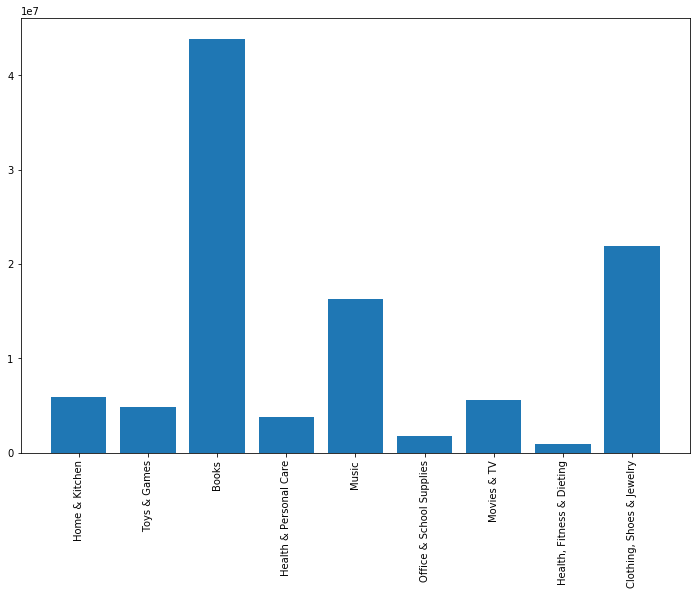

In [57]:
%%local
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

classes = ["Home & Kitchen", 
           "Toys & Games", 
           "Books", 
           "Health & Personal Care", 
           "Music", 
           "Office & School Supplies", 
           "Movies & TV", 
           "Health, Fitness & Dieting",
           "Clothing, Shoes & Jewelry"]
x = np.arange(len(classes))
y = np.array([5912704, 4819928, 43896101, 3763488, 16272754, 1782243, 5569474, 891499, 21938858])

plt.figure(figsize=(12, 8))
plt.bar(x, y)
plt.xticks(x, classes, rotation=90)
plt.show()

We need to decide upon a balnacing technique otherwise we might be swkewing the results towards one category

Before continuing, let's write a subset of reviews of associated with the first 10000 porduct metadata for testing the pipeline

In [9]:
val product_subset = metadata_df.limit(10000)
product_reviews.join(product_subset, "asin").limit(10000).write.mode("overwrite").json(s"$base_path/amazon/product/reviews/")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

product_subset: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [_corrupt_record: string, asin: string ... 8 more fields]


In [12]:
%%sql
select * from product_reviews limit 10

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

In [15]:
%%sql
select pc.category, pc.title, pc.description, pr.summary, pr.reviewText as review_text
from product_categories pc inner join product_reviews pr on pc.asin = pr.asin
limit 100

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

In [13]:
%%sql
select pc.category, collect_set(pc.title) as titles
from product_categories pc
where category = "Books"
group by pc.category
limit 10

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
Invalid status code '400' from http://localhost:8998/sessions/4/statements/13 with error payload: {"msg":"requirement failed: Session isn't active."}


In [14]:
print("hello")

An error was encountered:
Invalid status code '404' from http://localhost:8998/sessions/4 with error payload: {"msg":"Session '4' not found."}


In [5]:
metadata_df.select("*").limit(100).show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+----------+----------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+
|_corrupt_record|      asin|     brand|          categories|         description|               imUrl|price|             related|           salesRank|               title|
+---------------+----------+----------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+
|           null|0001048791|      null|           [[Books]]|                null|http://ecx.images...| null|                null|[,,,,, 6334800,,,...|The Crucible: Per...|
|           null|0000143561|      null|[[Movies & TV, Mo...|3Pack DVD set - I...|http://g-ecx.imag...|12.99|[, [B0036FO6SI, B...|[,,,,,,,,,,,,,,,,...|Everyday Italian ...|
|           null|0000037214|Big Dreams|[[Clothing, Shoes...|                null|http://ecx.images...| 6.99|[, [B00JO8II76, B...|[,,,,,,,, 1

## Preparing data for testing
This section contains the execution of the same queries as above but applied to the subsets created in the previous two cells. This is meant to generate the expected results for the pipeline.

In [14]:
val metadata_df = spark.read.json(s"$base_path/amazon/product/metadata")
val reviews_df = spark.read.json(s"$base_path/amazon/product/reviews")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

metadata_df: org.apache.spark.sql.DataFrame = [_corrupt_record: string, asin: string ... 8 more fields]
reviews_df: org.apache.spark.sql.DataFrame = [asin: string, brand: string ... 15 more fields]


### Transform the metadata

In [15]:
val textBlacklistRegex: String = "&.+;|'+|\"+|[@#$%^&*<>_-]"

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

textBlacklistRegex: String = &.+;|'+|"+|[@#$%^&*<>_-]


In [16]:
import spark.implicits._
import org.apache.spark.sql.functions._

//We need to double explode the records to get the categories separated.
val product_metadata = metadata_df.select($"asin", 
                   explode($"categories").as("categories"),
                   $"title",
                   $"description").
    select($"asin", 
           explode($"categories").as("category"), 
           trim(regexp_replace($"description", textBlacklistRegex, "")).as("description"), 
           trim(regexp_replace($"title", textBlacklistRegex, "")).as("title"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

import spark.implicits._
import org.apache.spark.sql.functions._
product_metadata: org.apache.spark.sql.DataFrame = [asin: string, category: string ... 2 more fields]


In [17]:
val categoryMapping = """
categories:
  - name: "Movies & TV"
    mappings:
      - Movies
      - Movies & TV
  - name: "Clothing, Shoes & Jewelry"
    mappings:
      - Clothing
      - T-Shirts
      - Shirts
      - Jewelry
      - Dresses
      - Boots
      - Shoes
      - "Jewelry: International Shipping Available"
      - "Shoes & Accessories: International Shipping Available"
      - "Clothing, Shoes & Jewelry"
      - Fashion
      - Earrings
  - name: "Music"
    mappings:
      - Music
      - Digital Music
      - CDs & Vinyl
      - Pop
      - Jazz
      - Alternative Rock
      - Rock
      - World Music
      - Dance & Electronic
  - name: "Technology, Electronics & Accessories"
    mappings:
      - Electronics
      - Cell Phones & Accessories
      - Computers & Accessories
      - Camera & Photo
  - name: "Books"
    mappings:
      - Books
      - Kindle eBooks
      - Kindle Store
      - Literature & Fiction
      - Kindle Short Reads
      - Christian Books & Bibles
  - name: "Toys & Games"
    mappings:
      - Games
      - Toys & Games
  - name: "Home & Kitchen"
    mappings:
      - Home & Kitchen
      - Kitchen & Dining
  - name: "Office & School Supplies"
    mappings:
      - Office & School Supplies
      - Office Products
  - name: "Health & Personal Care"
    mappings:
      - Hair Care
      - Skin Care
      - Health & Personal Care
  - name: "Health, Fitness & Dieting"
    mappings:
      - Athletic
      - Health, Fitness & Dieting
"""

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

categoryMapping: String =
"
categories:
  - name: "Movies & TV"
    mappings:
      - Movies
      - Movies & TV
  - name: "Clothing, Shoes & Jewelry"
    mappings:
      - Clothing
      - T-Shirts
      - Shirts
      - Jewelry
      - Dresses
      - Boots
      - Shoes
      - "Jewelry: International Shipping Available"
      - "Shoes & Accessories: International Shipping Available"
      - "Clothing, Shoes & Jewelry"
      - Fashion
      - Earrings
  - name: "Music"
    mappings:
      - Music
      - Digital Music
      - CDs & Vinyl
      - Pop
      - Jazz
      - Alternative Rock
      - Rock
      - World Music
      - Dance & Electronic
  - name: "Technology, Electronics & Accessories"
    mappings:
      - Electronics
      - Cell Phones & Accessories
      - Computers & Ac...

In [18]:
import cats.syntax.either._
import io.circe._
import io.circe.generic.auto._
import io.circe.yaml

case class Category(name: String, mappings: List[String])
case class CategoryMapping(categories: List[Category])

val json = yaml.parser.parse(categoryMapping)

val mapping = json.leftMap(err => err:Error).
flatMap(_.as[CategoryMapping]).
valueOr(throw _)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

import cats.syntax.either._
import io.circe._
import io.circe.generic.auto._
import io.circe.yaml
defined class Category
defined class CategoryMapping
json: Either[io.circe.ParsingFailure,io.circe.Json] =
Right({
  "categories" : [
    {
      "name" : "Movies & TV",
      "mappings" : [
        "Movies",
        "Movies & TV"
      ]
    },
    {
      "name" : "Clothing, Shoes & Jewelry",
      "mappings" : [
        "Clothing",
        "T-Shirts",
        "Shirts",
        "Jewelry",
        "Dresses",
        "Boots",
        "Shoes",
        "Jewelry: International Shipping Available",
        "Shoes & Accessories: International Shipping Available",
        "Clothing, Shoes & Jewelry",
        "Fashion",
        "Earrings"
      ]
    },
    {
      "name" : "Music",
      "mappings" : [
        "Music",
        "Digital Music",
        "CDs & Vinyl",
        "Pop",
        "Jazz",
        "Alternative Rock",
        "Rock",
    ...mapping: CategoryMapping = CategoryMapping(List(C

In [19]:
val categoryMap = mapping.categories.map(category => category.name -> category.mappings).toMap
val categories = mapping.categories.map(category => category.name)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

categoryMap: scala.collection.immutable.Map[String,List[String]] = Map(Toys & Games -> List(Games, Toys & Games), Technology, Electronics & Accessories -> List(Electronics, Cell Phones & Accessories, Computers & Accessories, Camera & Photo), Books -> List(Books, Kindle eBooks, Kindle Store, Literature & Fiction, Kindle Short Reads, Christian Books & Bibles), Movies & TV -> List(Movies, Movies & TV), Music -> List(Music, Digital Music, CDs & Vinyl, Pop, Jazz, Alternative Rock, Rock, World Music, Dance & Electronic), Home & Kitchen -> List(Home & Kitchen, Kitchen & Dining), Clothing, Shoes & Jewelry -> List(Clothing, T-Shirts, Shirts, Jewelry, Dresses, Boots, Shoes, Jewelry: International Shipping Available, Shoes & Accessories: International Shipping Available, Clothing, Shoes & Jewelry,...categories: List[String] = List(Movies & TV, Clothing, Shoes & Jewelry, Music, Technology, Electronics & Accessories, Books, Toys & Games, Home & Kitchen, Office & School Supplies, Health & Personal C

To query and transform the categories

In [20]:
val transformedMetadata = product_metadata.select($"asin", $"title", trim($"description").as("description"),
                            when($"category".isin(categoryMap("Movies & TV"):_*), "Movies & TV").
                            when($"category".isin(categoryMap("Clothing, Shoes & Jewelry"):_*), "Clothing, Shoes & Jewelry").
                            when($"category".isin(categoryMap("Music"):_*), "Music").
                            when($"category".isin(categoryMap("Technology, Electronics & Accessories"):_*), "Technology, Electronics & Accessories").
                            when($"category".isin(categoryMap("Books"):_*), "Books").
                            when($"category".isin(categoryMap("Toys & Games"):_*), "Toys & Games").
                            when($"category".isin(categoryMap("Home & Kitchen"):_*), "Home & Kitchen").
                            when($"category".isin(categoryMap("Office & School Supplies"):_*), "Office & School Supplies").
                            when($"category".isin(categoryMap("Health & Personal Care"):_*), "Health & Personal Care").
                            when($"category".isin(categoryMap("Health, Fitness & Dieting"):_*), "Health, Fitness & Dieting").
                            otherwise("skip").as("category")).where($"category".isNotNull && $"category" =!= "skip")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

transformedMetadata: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [asin: string, title: string ... 2 more fields]


In [21]:
transformedMetadata.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

res17: Long = 8848


In [22]:
val firstCategoryName = categories.head
val firstCase = when($"category".isin(categoryMap(firstCategoryName):_*), firstCategoryName)

val categoryColumn = categories.tail.foldLeft(firstCase){(column, category) =>
      column.when($"category".isin(categoryMap(category):_*), category)
    }

 product_metadata.select($"asin",
      trim($"title").as("title"),
      trim($"description").as("description"),
      categoryColumn.as("category")).
      where("category is not null").count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

firstCategoryName: String = Movies & TV
firstCase: org.apache.spark.sql.Column = CASE WHEN (category IN (Movies, Movies & TV)) THEN Movies & TV END
categoryColumn: org.apache.spark.sql.Column = CASE WHEN (category IN (Movies, Movies & TV)) THEN Movies & TV WHEN (category IN (Clothing, T-Shirts, Shirts, Jewelry, Dresses, Boots, Shoes, Jewelry: International Shipping Available, Shoes & Accessories: International Shipping Available, Clothing, Shoes & Jewelry, Fashion, Earrings)) THEN Clothing, Shoes & Jewelry WHEN (category IN (Music, Digital Music, CDs & Vinyl, Pop, Jazz, Alternative Rock, Rock, World Music, Dance & Electronic)) THEN Music WHEN (category IN (Electronics, Cell Phones & Accessories, Computers & Accessories, Camera & Photo)) THEN Technology, Electronics & Accessories WHEN (category IN (Books, Kindle eBooks, Kindle Store, Literature & Fiction, Kindle Short Reads, Christian Books & Bibles)) THEN Books WHEN (category IN (G...res20: Long = 8848


In [23]:
transformedMetadata.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+--------------------+--------------------+--------------------+
|      asin|               title|         description|            category|
+----------+--------------------+--------------------+--------------------+
|0001048791|The Crucible: Per...|                null|               Books|
|0000143561|Everyday Italian ...|3Pack DVD set  It...|         Movies & TV|
|0000143561|Everyday Italian ...|3Pack DVD set  It...|         Movies & TV|
|0000037214|Purple Sequin Tin...|                null|Clothing, Shoes &...|
|0000037214|Purple Sequin Tin...|                null|Clothing, Shoes &...|
|0000032069|Adult Ballet Tutu...|                null|Clothing, Shoes &...|
|0000032034|Adult Ballet Tutu...|                null|Clothing, Shoes &...|
|0000589012|Why Dont They Jus...|                null|         Movies & TV|
|0000589012|Why Dont They Jus...|                null|         Movies & TV|
|0001048775|Measure for Measu...|William Shakespea...|               Books|
+----------+

Now we want to aggregate the products with multiple categories to reduce disk space usage and enable multi-label classification

In [38]:
val finalMetadata = transformedMetadata.groupBy($"asin", $"title", $"description").agg(collect_set($"category").as("categories"))
finalMetadata.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

finalMetadata: org.apache.spark.sql.DataFrame = [asin: string, title: string ... 2 more fields]
+----------+--------------------+--------------------+----------+
|      asin|               title|         description|categories|
+----------+--------------------+--------------------+----------+
|0002555166|Double Lives: Sta...|                null|   [Books]|
|0004488172|Collins Scotland ...|                null|   [Books]|
|0005546915|Norton Introducti...|                null|   [Books]|
|0006110452|Psychology: Conce...|                null|   [Books]|
|0006159990|  Murder in the Mews|                null|   [Books]|
|0006266843|The Gospel from O...|                null|   [Books]|
|0006331750|r. d. laing (Mode...|                null|   [Books]|
|0006380387|Lifes Little Insp...|From the author o...|   [Books]|
|0006387403|The Pale Abyssini...|Miles Bredin, bor...|   [Books]|
|0006392202|          Lost Girls|                null|   [Books]|
+----------+--------------------+-------------

Let's save this as an expected result for the pipelines

In [39]:
finalMetadata.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

res37: Long = 8802


Write the metadata as is

In [26]:
finalMetadata.repartition(1).write.mode("overwrite").parquet(s"$base_path/amazon/product/metadata_expected/")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Now we need to generate the product documents

In [27]:
val metadataDocuments = finalMetadata.select($"categories", 
                            concat(when($"title".isNotNull && length($"title") >= 3, concat($"title", lit("\n"))).otherwise(lit("")), 
                                when($"description".isNotNull && length($"description") >= 3, concat($"description", lit("\n"))).otherwise(lit(""))).as("document")).
                            where(length($"document") >= 100)
            

metadataDocuments.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

metadataDocuments: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [categories: array<string>, document: string]
+----------+--------------------+
|categories|            document|
+----------+--------------------+
|   [Books]|Lifes Little Insp...|
|   [Books]|The Pale Abyssini...|
|   [Books]|Lady of Hay
Erski...|
|   [Books]|Zigby Hunts for T...|
|   [Books]|Falklands Command...|
|   [Books]|You Can Paint Flo...|
|   [Books]|Boneland
From Har...|
|   [Books]|The Ten Principal...|
|   [Books]|Monetary Economic...|
|   [Books]|50 Great Business...|
+----------+--------------------+
only showing top 10 rows



In [28]:
metadataDocuments.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

res28: Long = 3289


In [29]:
metadataDocuments.where($"document".contains("The Perfect Sinner")).collect()(0)(1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

res29: Any =
"The Perfect Sinner
Vivid scenes of warfare and the harshness of mediaeval life...the descriptions of Sir Guys journey from hopeful youth to weathered witness are imbued with the authenticity of the period Historical Novel Society magazine This involving story has humour and passion, but also poses questions about the morality of waging war, and the courage necessary to fight in it or to stand against it. Good Book Guide Will Davenport has written a powerful novel about a journey across Europe in the fourteenth century by a man reviewing his own past and his own sin. The characters are utterly convincing as they struggle with the wild conditions of mediaeval Europe and their own guilts and fears. This is also a timeshift book. The heros modern descendant is facing her own d...

Persist this documents

In [30]:
metadataDocuments.repartition(1).write.mode("overwrite").parquet(s"$base_path/amazon/product/metadata_documents")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
product_metadata.groupBy($"category").agg(count($"asin").as("products")).where($"products" > 10).select($"category").collect().map(_.getString(0))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

res31: Array[String] = Array(CDs & Vinyl, Movies, Books, Movies & TV)


Aggregate the categories again, preparing for multi-label classification

### Reviews transformation

In [33]:
reviews_df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- asin: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)
 |-- description: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- imUrl: string (nullable = true)
 |-- overall: double (nullable = true)
 |-- price: double (nullable = true)
 |-- related: struct (nullable = true)
 |    |-- also_bought: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- also_viewed: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- bought_together: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- buy_after_viewing: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- rev

In [34]:
reviews_df.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----+----------+--------------------+-------+--------------------+-------+-----+--------------------+--------------------+-----------+--------------------+--------------------+------------+--------------------+--------------------+--------------+
|      asin|brand|categories|         description|helpful|               imUrl|overall|price|             related|          reviewText| reviewTime|          reviewerID|        reviewerName|   salesRank|             summary|               title|unixReviewTime|
+----------+-----+----------+--------------------+-------+--------------------+-------+-----+--------------------+--------------------+-----------+--------------------+--------------------+------------+--------------------+--------------------+--------------+
|000727405X| null| [[Books]]|Now thirty four y...| [0, 0]|http://ecx.images...|    4.0| 3.79|[[0007256817, 033...|It really does ha...|03 11, 2013|A00039763E5V43M02...|           MsDreinca|[2661726,,,]|We need to know th

In [35]:
reviews_df.select($"asin", $"title", $"summary", $"reviewText").show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+--------------------+--------------------+--------------------+
|      asin|               title|             summary|          reviewText|
+----------+--------------------+--------------------+--------------------+
|000727405X|Cry Silent Tears:...|We need to know this|It really does ha...|
|0007444117|Allegiant (Diverg...|Allegiant a great...|Great book. Veron...|
|0007124015|The Lord of the R...|A set of books th...|I was dyslexic an...|
|0002007770| Water For Elephants|           Good book|I read this after...|
|0007124015|The Lord of the R...|One of the all ti...|This was my secon...|
|0002213184| How Young They Died|I enjoyed reading...|A very good novel...|
|0002007770| Water For Elephants| Water For Elephants|Water For Elephan...|
|0007179731|The Monk Who Sold...|The Monk Who Sold...|Are you tired of ...|
|0007444117|Allegiant (Diverg...|Great read; great...|I think it's funn...|
|0007136838|And Then There We...|              Review|A very good book....|
+----------+

As we observe, the column "title" corresponds to the product title, we are going to omit this in favor of the one coming from the product metadata data frame

We observe that some text contains trash characters, let's clean the text as part of the transformation.

In [40]:
val finalReviews = reviews_df.select($"asin", $"summary", $"reviewText".as("review_text")).
    where($"review_text".isNotNull && (length($"review_text") >= 100)).
    join(finalMetadata, "asin").
    select($"categories", 
           trim(regexp_replace($"summary", textBlacklistRegex, "")).as("summary"), 
           trim(regexp_replace($"review_text", textBlacklistRegex, "")).as("review_text")).
    orderBy($"summary")
finalReviews.show(20)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

finalReviews: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [categories: array<string>, summary: string ... 1 more field]
+----------+--------------------+--------------------+
|categories|             summary|         review_text|
+----------+--------------------+--------------------+
|   [Books]|                    |This is the kind ...|
|   [Books]|                    |So good, but such...|
|   [Books]|                   .|If you have alrea...|
|   [Books]|                   .|My husband cant p...|
|   [Books]|... Horrible.  Ju...|Just for a brief ...|
|   [Books]|     ... I cant even|I hate it when pe...|
|   [Books]|... now everyone ...|Well by now every...|
|   [Books]|...and all I see ...|Im a GRRM late bl...|
|   [Books]|...when a man smi...|The Trident is a ...|
|   [Books]|1 star for the st...|So, this is the d...|
|   [Books]|10 Minute Guide t...|As a consultant w...|
|   [Books]|10 give or take w...|This book had me ...|
|   [Books]|  100 sucess rate!!!|Ive been 

In [41]:
finalReviews.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

res39: Long = 9727


In [42]:
finalReviews.repartition(1).write.mode("overwrite").parquet(s"$base_path/amazon/product/reviews_expected/")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [43]:
finalReviews.take(1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

res41: Array[org.apache.spark.sql.Row] = Array([WrappedArray(Books),,This is the kind of story a grandpa would tell over and over again. I did not buy the book but I wish I had. And for only 4 on the kindle, its a steal! I cannot wait to see the movie. The best part is that this is just one story of the old mans life. And I would like to hear more! It will keep you turning pages until there are no more to turn!])


Now let's generate the review documents

In [44]:
val reviewDocuments = finalReviews.select($"categories",
          concat(when($"summary".isNotNull && length($"summary") >= 3, concat($"summary", lit("\n"))).otherwise(lit("")), 
                 when($"review_text".isNotNull && length($"review_text") >= 3, concat($"review_text", lit("\n"))).otherwise(lit(""))).as("document")).
          where(length($"document") >= 100)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

reviewDocuments: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [categories: array<string>, document: string]


In [45]:
reviewDocuments.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+--------------------+
|categories|            document|
+----------+--------------------+
|   [Books]|This is the kind ...|
|   [Books]|So good, but such...|
|   [Books]|My husband cant p...|
|   [Books]|If you have alrea...|
|   [Books]|... Horrible.  Ju...|
|   [Books]|... I cant even
I...|
|   [Books]|... now everyone ...|
|   [Books]|...and all I see ...|
|   [Books]|...when a man smi...|
|   [Books]|1 star for the st...|
+----------+--------------------+
only showing top 10 rows



And make a union between the product documents and the reviews documents

In [46]:
finalReviews.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

res43: Long = 9727


In [47]:
reviewDocuments.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

res44: Long = 9715


In [48]:
val fullDocuments = metadataDocuments.union(reviewDocuments)
fullDocuments.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

fullDocuments: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [categories: array<string>, document: string]
+----------+--------------------+
|categories|            document|
+----------+--------------------+
|   [Books]|Lifes Little Insp...|
|   [Books]|The Pale Abyssini...|
|   [Books]|Lady of Hay
Erski...|
|   [Books]|Zigby Hunts for T...|
|   [Books]|Falklands Command...|
|   [Books]|You Can Paint Flo...|
|   [Books]|Boneland
From Har...|
|   [Books]|The Ten Principal...|
|   [Books]|Monetary Economic...|
|   [Books]|50 Great Business...|
+----------+--------------------+
only showing top 10 rows



In [49]:
reviewDocuments.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

res46: Long = 9715


In [50]:
metadataDocuments.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

res47: Long = 3289


In [51]:
fullDocuments.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

res48: Long = 13004


Finally persist this data frame in both, the category as array form and as a comma separated string form

In [52]:
fullDocuments.repartition(1).write.mode("overwrite").parquet(s"$base_path/amazon/product/full_documents/")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [53]:
fullDocuments.select(array_join($"categories", ";").as("categories"), $"document").
    repartition(1).write.mode("overwrite").parquet(s"$base_path/amazon/product/full_documents_str_cat/")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
finalMetadata.createOrReplaceTempView("product_metadata")
reviews_df.createOrReplaceTempView("product_reviews")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
%%sql
select pm.asin, explode(pm.categories) as categories, pm.title, pm.description, pr.summary, pr.reviewText as review_text
from product_metadata pm inner join product_reviews pr on pr.asin = pm.asin
where pr.reviewText is not null and length(pr.reviewText) > 100
order by pm.title
limit 10

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

In [31]:
%%sql
select pm.categories, count(pr.summary)
from product_metadata pm inner join product_reviews pr on pr.asin = pm.asin
group by pm.categories

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

We have severely imbalanced products by category, since our purpose is the extract features per category, we need to better sample the items from each category

In [60]:
val testReviews = spark.read.parquet(s"$base_path/amazon/product/reviews_expected/")
testReviews.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

testReviews: org.apache.spark.sql.DataFrame = [categories: array<string>, title: string ... 3 more fields]
root
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- title: string (nullable = true)
 |-- description: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- review_text: string (nullable = true)



In [63]:
finalReviews.collect()(9200)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

res64: org.apache.spark.sql.Row = [WrappedArray(Books),Water For Elephants,null,Fantastic read!,Jacob Jankowski is just about through with veterinary school when fate switches things up a bit and turns his world upside down.  He decides to hop a train and ends up in the middle of the Benzini Brothers Most Spectacular Show on Earth.  The Great Depression was just in its early stages so for Jacob having a paying job was lucky but he also found parts of the circus life to be a living hell.  As he was just shy of his degree, Jacob ends up being put in charge of the menagerie, the starring animals of the show.He then meets Marlena, the beautiful equestrian act star who happens to be married to August, the twisted and manipulative animal trainer for the show.Uncle Al, the big boss of the Benz...

In [67]:
val pm = spark.read.parquet(s"$base_path/amazon/product/metadata_expected/")
val rv = reviews_df.select($"asin", $"summary", $"reviewText".as("review_text")).
    join(pm, "asin").
    select($"asin",
        $"categories", 
           $"title", 
           $"description", 
           trim(regexp_replace($"summary", "&.+;|'+|[@#$%^&*<>_-]", "")).as("summary"), 
           trim(regexp_replace($"review_text", "&.+;|'+|[@#$%^&*<>_-]", "")).as("review_text")).
    orderBy($"title")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

pm: org.apache.spark.sql.DataFrame = [asin: string, title: string ... 2 more fields]
rv: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [asin: string, categories: array<string> ... 4 more fields]


In [68]:
rv.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+----------+--------------------+--------------------+--------------------+--------------------+
|      asin|categories|               title|         description|             summary|         review_text|
+----------+----------+--------------------+--------------------+--------------------+--------------------+
|0030188717|   [Books]|                null|                null|What Journalism r...|I was a student o...|
|0030188717|   [Books]|                null|                null|Interesting book ...|I bought this on ...|
|0028603540|   [Books]|1,000 Lowfat Reci...|With1000 Lowfat R...|The best cookbook...|I was never much ...|
|0028603540|   [Books]|1,000 Lowfat Reci...|With1000 Lowfat R...|Rely on this cook...|I took a cooking ...|
|0025429655|   [Books]|1,000 Vegetarian ...|1,000 Vegetarian ...| always a bestseller|This book is one ...|
|0025429655|   [Books]|1,000 Vegetarian ...|1,000 Vegetarian ...|   Our everyday goto|In our house, we ...|
|0025429655|   [Books]|1,000

In [74]:
rv.where($"title".isNotNull || ($"asin" === "0028603540")).show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+----------+--------------------+--------------------+--------------------+--------------------+
|      asin|categories|               title|         description|             summary|         review_text|
+----------+----------+--------------------+--------------------+--------------------+--------------------+
|0030188717|   [Books]|                null|                null|What Journalism r...|I was a student o...|
|0030188717|   [Books]|                null|                null|Interesting book ...|I bought this on ...|
|0028603540|   [Books]|1,000 Lowfat Reci...|With1000 Lowfat R...|Rely on this cook...|I took a cooking ...|
|0028603540|   [Books]|1,000 Lowfat Reci...|With1000 Lowfat R...|The best cookbook...|I was never much ...|
+----------+----------+--------------------+--------------------+--------------------+--------------------+



## Exploring the final result

In [3]:
val training_documents = spark.read.parquet("/media/ohtar10/Adder-Storage/datasets/amazon/rev_prod_documents/10m")
training_documents.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

training_documents: org.apache.spark.sql.DataFrame = [categories: string, document: string]
res2: Long = 8914930


In [4]:
training_documents.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+
|          categories|            document|
+--------------------+--------------------+
|Technology, Elect...|64 Gb USB 2.0 Mem...|
|         Books;Music|Ace Collins is th...|
|               Books|Great Houses of N...|
|               Books|The Book of Impor...|
|               Books|Eiriksdottir: A T...|
|Clothing, Shoes &...|Texas Longhorns U...|
|Technology, Elect...|South Carolina 15...|
|Health & Personal...|NEW AVON ~ Anew R...|
|        Toys & Games|Laser Pegs AC Pow...|
|Technology, Elect...|BMW iPHONE 5 5S 5...|
+--------------------+--------------------+
only showing top 10 rows



In [7]:
training_documents.select(split($"categories", ";").as("categories")).
select(explode($"categories").as("categories"), lit(1).as("document")).
createOrReplaceTempView("training_reviews")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
%%sql -o cat_count
select categories, count(*) as reviews
from training_reviews
group by categories

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

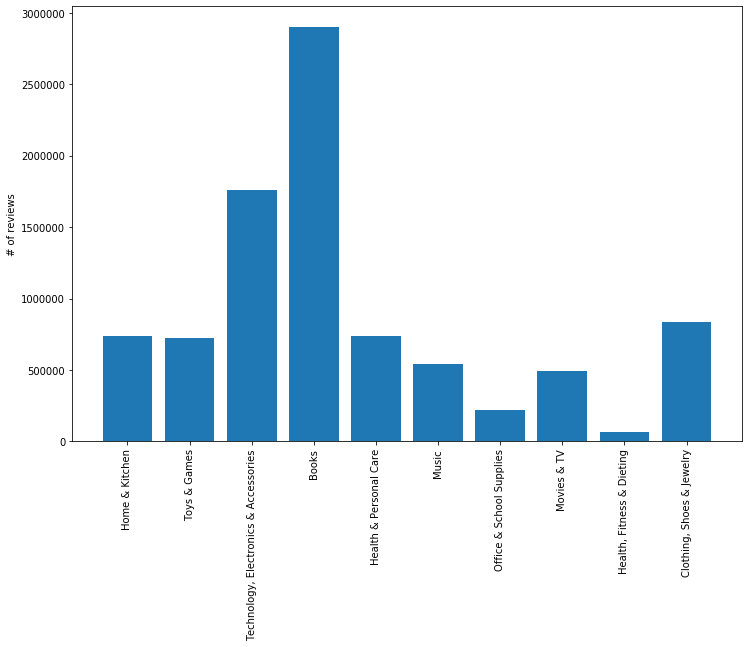

In [9]:
%%local
%matplotlib inline
import matplotlib.pyplot as plt

categories = cat_count.categories.values
counts = cat_count.reviews.values

plt.figure(figsize=(12, 8))
plt.bar(categories, counts)
plt.xticks(categories, rotation=90)
plt.ylabel("# of reviews")
plt.show()